In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import * 
from scipy.optimize import newton
from scipy.optimize import fsolve
import warnings
warnings.ignore = True

Given the input, the price of the MBS is : 100510.885894


No handles with labels found to put in legend.


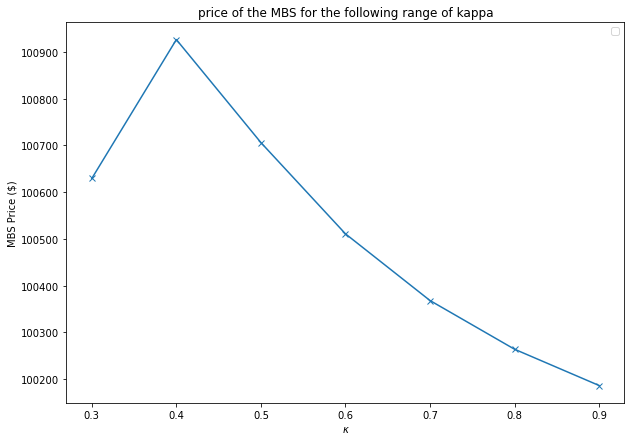

No handles with labels found to put in legend.


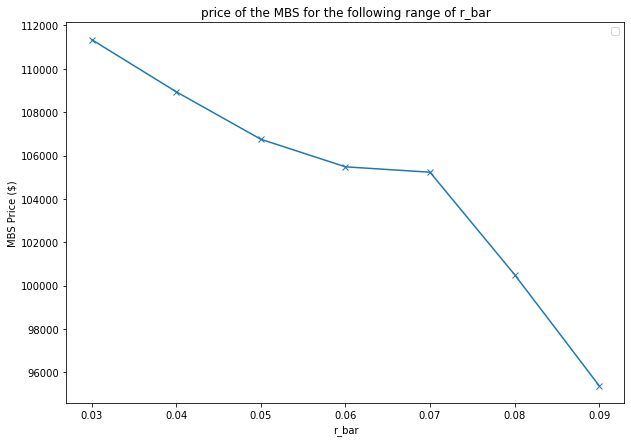

In [2]:
#1a
def CIR(kappa, rbar, sig, r_tmin1):
    h1 = np.sqrt(kappa**2+2*sig**2)
    h2 = (kappa+h1)/2
    h3 = 2*kappa*rbar/sig**2
    B_T1T2 = (np.exp(h1*10)-1)/(h2*(np.exp(h1*10)-1)+h1)
    temp = h1*np.exp(h2*10)/(h2*(np.exp(h1*10)-1)+h1)
    A_T1T2 = np.power(temp, h3)
    r_tmin1_10 = -np.log(A_T1T2*np.exp(-B_T1T2*r_tmin1))/10
    return r_tmin1_10
CIR = np.vectorize(CIR)

def CPR_step_i(WAC, r_tmin1, PV_t_1,PV0, sig, kappa, rbar, SG_t, SY_t):
    r_tmin1_10 = CIR(kappa=kappa, rbar=rbar, sig=sig, r_tmin1=r_tmin1)
    RI_t = 0.28+0.14*np.arctan(-8.57+430*(WAC-r_tmin1_10))
    BU_t = 0.3 + 0.7*PV_t_1/PV0
    return RI_t*BU_t*SG_t*SY_t

def MBS_price(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12):
    dt = 1/120 #Set  the time interval to 1/120 year
    n = int(12 * T)
    M = 2000
    step = int(round(T / dt))
    rt = np.zeros((M, step + 1))
    rt[:, 0] = r0
    np.random.seed(713)
    for i in range(step):
        zt = np.random.normal(0, 1, M)
        rt[:, i + 1] = rt[:, i] + kappa * (rbar - rt[:, i]) * dt + sig * np.sqrt(np.abs(rt[:, i])) * np.sqrt(dt) * zt
    R = np.zeros((M, n))
    SY = np.zeros(n)
    PV = np.zeros((M, n))
    PV[:, 0] = L0
    ct = np.zeros((M, n))
    r = WAC/12
    for i in range(n):
        R[:, i] = np.sum(rt[:, 1:(10 * i + 11)], axis=1) * (-dt)
        r_tmin1_i = rt[:, 10 * i]
        SG_i= np.minimum(1, (i + 1) / 30)
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        CPR_i = CPR_step_i(WAC=WAC, r_tmin1=r_tmin1_i, PV_t_1=PV[:, i], PV0=L0, sig=sig, kappa=kappa, rbar=rbar, SG_t=SG_i, SY_t=SY[i])
        ct[:, i] = PV[:, i] * r / (1 - np.power(1 + r, i - n)) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                        1 - np.power((1 - CPR_i), 1 / 12))
        TPP_i = PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                         1 - np.power((1 - CPR_i), 1 / 12))
        if i < (n-1):
            PV[:, i + 1] = PV[:, i] - TPP_i
    disc = np.exp(R)
    MBS_price = np.mean(np.sum(np.multiply(disc, ct), axis=1))
    return MBS_price
MBS_price = np.vectorize(MBS_price)

q1a = MBS_price(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12)
print("Given the input, the price of the MBS is : %.6f" % q1a)

#1b
np.random.seed(9)
kappa_list = np.array([0.3 + 0.1*i for i in range(7)])
MBS_kappa = MBS_price(kappa=kappa_list)
plt.figure(figsize=(10,7))
plt.plot(kappa_list, MBS_kappa, marker='x', linestyle='-')
plt.title("price of the MBS for the following range of kappa")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()

#1c
rbar_list = np.array([0.03 + 0.01*i for i in range(7)])
MBS_rbar = MBS_price(rbar=rbar_list)
plt.figure(figsize=(10,7))
plt.plot(rbar_list, MBS_rbar, marker='x', linestyle='-')
plt.title("price of the MBS for the following range of r_bar")
plt.xlabel("r_bar")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()

In [3]:
#2
def OAS_MBS(MarketPrice, T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12):
    dt = 1/120
    n = int(12 * T)
    M = 2000
    step = int(round(T / dt))
    rt = np.zeros((M, step + 1))
    rt[:, 0] = r0
    for i in range(step):
        zt = np.random.normal(0, 1, M)
        rt[:, i + 1] = rt[:, i] + kappa * (rbar - rt[:, i]) * dt + sig * np.sqrt(np.abs(rt[:, i])) * np.sqrt(dt) * zt
    R = np.zeros((M, n))
    SY = np.zeros(n)
    PV = np.zeros((M, n))
    PV[:, 0] = L0
    ct = np.zeros((M, n))
    ind = np.zeros((M, n))
    r = WAC/12
    for i in range(n):
        R[:, i] = np.sum(rt[:, 1:(10 * i + 11)], axis=1) * (-dt)
        r_tmin1_i = rt[:, 10 * i]
        SG_i= np.minimum(1, (i + 1) / 30)
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        CPR_i = CPR_step_i(WAC=WAC, r_tmin1=r_tmin1_i, PV_t_1=PV[:, i], PV0=L0, sig=sig, kappa=kappa, rbar=rbar, SG_t=SG_i, SY_t=SY[i])
        ct[:, i] = PV[:, i] * r / (1 - np.power(1 + r, i - n)) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                        1 - np.power((1 - CPR_i), 1 / 12))
        TPP_i = PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                         1 - np.power((1 - CPR_i), 1 / 12))
        ind[:, i] = i
        if i < (n-1):
            PV[:, i + 1] = PV[:, i] - TPP_i
    fx = lambda x: np.mean(np.sum(np.multiply(np.exp(R - ind*x*10*dt), ct), axis=1)) - MarketPrice
    oas = fsolve(fx, 0)
    return oas


q2 = OAS_MBS(MarketPrice=110000)
print("Given the market price of 110000, the OAS is : %.6f" % q2)

Given the market price of 110000, the OAS is : -0.012784


In [4]:
#3
def pertubPrice(MarketPrice=110000, T=30, L0=100000, WAC=0.08, r0=0.078, a=0.36, b=-5.86, y = 0.2,sig=0.3):
    dt = 1/120
    n = int(12 * T)
    M = 2000
    step = int(round(T / dt))
    rt = np.zeros((M, step + 1))
    rt[:, 0] = r0
    for i in range(step):
        zt = np.random.normal(0, 1, M)
        rt[:, i + 1] = rt[:, i] + kappa * (rbar - rt[:, i]) * dt + sig * np.sqrt(np.abs(rt[:, i])) * np.sqrt(dt) * zt
    R = np.zeros((M, n))
    SY = np.zeros(n)
    PV = np.zeros((M, n))
    PV[:, 0] = L0
    ct = np.zeros((M, n))
    ind = np.zeros((M, n))
    r = WAC/12
    for i in range(n):
        R[:, i] = np.sum(rt[:, 1:(10 * i + 11)], axis=1) * (-dt)
        r_tmin1_i = rt[:, 10 * i]
        SG_i= np.minimum(1, (i + 1) / 30)
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        CPR_i = CPR_step_i(WAC=WAC, r_tmin1=r_tmin1_i, PV_t_1=PV[:, i], PV0=L0, sig=sig, kappa=kappa, rbar=rbar, SG_t=SG_i, SY_t=SY[i])
        ct[:, i] = PV[:, i] * r / (1 - np.power(1 + r, i - n)) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                        1 - np.power((1 - CPR_i), 1 / 12))
        TPP_i = PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                         1 - np.power((1 - CPR_i), 1 / 12))
        ind[:, i] = i
        if i < (n-1):
            PV[:, i + 1] = PV[:, i] - TPP_i
    fx = lambda x: np.mean(np.sum(np.multiply(np.exp(R - ind*x*10*dt), ct), axis=1)) - MarketPrice
    oas = fsolve(fx, 0)
    y = 0.0005
    P0 = MarketPrice
    P_plus = np.mean(np.sum(np.multiply(np.exp(R - ind*(oas+y)*10*dt), ct), axis=1))
    P_minus = np.mean(np.sum(np.multiply(np.exp(R - ind*(oas-y)*10*dt), ct), axis=1))
    return P0, P_plus, P_minus

def OAS_duration(P_plus, P_minus, P0):
    y = 5*(0.01/100)
    duration = (P_minus - P_plus)/(2*y*P0)
    
    return duration
def OAS_convexity(P_plus, P_minus, P0):
    y = 5*(0.01/100)
    convexity = (P_minus + P_plus - 2*P0)/(2 * y **2 * P0)
    
    return convexity

P0, P_plus, P_minus = pertubPrice(MarketPrice=110000)
durationOAS = OAS_duration(P_plus, P_minus, P0)
convexityOAS = OAS_convexity(P_plus, P_minus, P0)
print("The OAS-duration is : ", durationOAS)
print("The OAS-convexity is : ", convexityOAS)

The OAS-duration is :  7.119886841945911
The OAS-convexity is :  45.006836640161715


   long run mean (r)   IO Price($)   PO Price($)
0               0.03  27206.279520  84287.110789
1               0.04  26851.673700  82216.677092
2               0.05  27203.672178  79688.186920
3               0.06  33731.620179  71791.470920
4               0.07  51126.055499  54256.428469
5               0.08  53633.991379  47072.104774
6               0.09  52391.958115  43204.060271


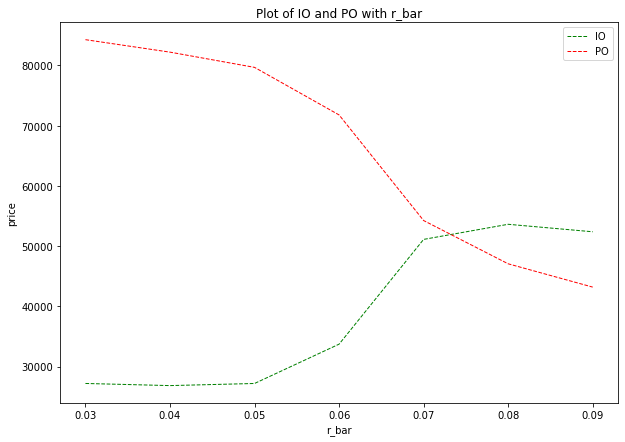

In [5]:
#4
def IO_PO(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12):
    dt = 1/120
    n = int(12 * T)
    M = 2000
    step = int(round(T / dt))
    rt = np.zeros((M, step + 1))
    rt[:, 0] = r0
    Interest = np.zeros((M, n))
    Principal = np.zeros((M, n))
    PV_previous = np.array([L0]*M)
    for i in range(step):
        zt = np.random.normal(0, 1, M)
        rt[:, i + 1] = rt[:, i] + kappa * (rbar - rt[:, i]) * dt + sig * np.sqrt(np.abs(rt[:, i])) * np.sqrt(dt) * zt
    R = np.zeros((M, n))
    SY = np.zeros(n)
    PV = np.zeros((M, n))
    PV[:, 0] = L0
    ct = np.zeros((M, n))
    r = WAC/12
    for i in range(n):
        R[:, i] = np.sum(rt[:, 1:(10 * i + 11)], axis=1) * (-dt)
        r_tmin1_i = rt[:, 10 * i]
        SG_i= np.minimum(1, (i + 1) / 30)
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        CPR_i = CPR_step_i(WAC=WAC, r_tmin1=r_tmin1_i, PV_t_1=PV[:, i], PV0=L0, sig=sig, kappa=kappa, rbar=rbar, SG_t=SG_i, SY_t=SY[i])
        ct[:, i] = PV[:, i] * r / (1 - np.power(1 + r, i - n)) + (PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        TPP_i = ct[:, i]-PV[:,i]*r
        Interest[:, i] = PV[:,i]*r
        Principal[:, i] =  TPP_i
        if i < (n-1):
            PV[:, i + 1] = PV[:, i] - TPP_i
            
    disc = np.exp(R)
    IO = np.mean(np.sum(np.multiply(disc, Interest), axis=1))
    PO = np.mean(np.sum(np.multiply(disc, Principal), axis=1))
    return [IO, PO]

r_bar = np.arange(0.03, 0.091, 0.01)
answers=pd.DataFrame(r_bar, columns=['long run mean (r)'])
answers['IO Price($)'] = [(IO_PO(rbar = i)[0]) for i in r_bar]
answers['PO Price($)'] = [(IO_PO(rbar = i)[1]) for i in r_bar]
print(answers)
plt.figure(figsize=(10,7))
plt.plot(answers['long run mean (r)'], answers['IO Price($)'], 'g--', linewidth=1, label="IO")
plt.title("Plot of IO and PO with r_bar")
plt.ylabel("price")
plt.xlabel("r_bar")
plt.plot(answers['long run mean (r)'], answers['PO Price($)'], 'r--', linewidth=1,label="PO")
plt.legend(loc='upper right')
plt.show()